In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
import cv2
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
import pickle

In [ ]:
train_images=pickle.load(
      open('/content/drive/MyDrive/datasets/BRAIN_TUMOR_DATA_STORE/train_images.pkl','rb'))
test_images=pickle.load(
      open('/content/drive/MyDrive/datasets/BRAIN_TUMOR_DATA_STORE/test_images.pkl','rb'))
TRAINING_LABELS=pickle.load(
      open('/content/drive/MyDrive/datasets/BRAIN_TUMOR_DATA_STORE/TRAINING_LABELS.pkl','rb'))
TESTING_LABELS=pickle.load(
      open('/content/drive/MyDrive/datasets/BRAIN_TUMOR_DATA_STORE/TESTING_LABELS.pkl','rb'))
train_masks=pickle.load(
      open('/content/drive/MyDrive/datasets/BRAIN_TUMOR_DATA_STORE/train_masks.pkl','rb'))
test_masks=pickle.load(
      open('/content/drive/MyDrive/datasets/BRAIN_TUMOR_DATA_STORE/test_masks.pkl','rb'))
train_borders=pickle.load(
    open('/content/drive/MyDrive/datasets/BRAIN_TUMOR_DATA_STORE/train_borders.pkl','rb'))
test_borders=pickle.load(
    open('/content/drive/MyDrive/datasets/BRAIN_TUMOR_DATA_STORE/test_borders.pkl','rb'))

In [ ]:
TRAIN_IMAGES=keras.layers.Conv1D(3,3,padding='same')(train_images)
TEST_IMAGES=keras.layers.Conv1D(3,3,padding='same')(test_images)

In [ ]:
TRAIN_IMAGES.shape

TensorShape([2800, 128, 128, 3])

In [ ]:
TEST_IMAGES.shape

TensorShape([264, 128, 128, 3])

Visual Geometry group

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19
Vgg=VGG19(include_top=False, weights='imagenet',input_shape=(128,128,3))

In [ ]:
Vgg.trainable=False

In [ ]:
N=2758
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    return lambda t: tfp.distributions.Independent(tfp.distributions.Normal(loc=tf.zeros(n, 
                      dtype=dtype),scale=1),reinterpreted_batch_ndims=1)

def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    return keras.models.Sequential([
        tfp.layers.VariableLayer(tfp.layers.IndependentNormal.params_size(n), dtype=dtype),
        tfp.layers.IndependentNormal(n)
    ])

In [ ]:
features=keras.layers.Flatten()(Vgg.output)
hidden_1=tfp.layers.DenseVariational(32, posterior, prior, kl_weight=1/N, activation='selu', 
                               )(features)
_hidden_=tfp.layers.DenseVariational(2, posterior, prior, kl_weight=1/N, activation='softmax', 
                               )(hidden_1)
__hidden__=tfp.layers.DenseVariational(2, posterior, prior, kl_weight=1/N, activation='softmax', 
                               )(hidden_1)
___hidden___=tfp.layers.DenseVariational(2, posterior, prior, kl_weight=1/N, activation='softmax', 
                               )(hidden_1)
output_1=tfp.layers.DistributionLambda(lambda t: tfp.distributions.Bernoulli(probs=t
                                                                    ))(_hidden_)
output_2=tfp.layers.DistributionLambda(lambda t: tfp.distributions.Bernoulli(probs=t
                                                                    ))(__hidden__)
output_3=tfp.layers.DistributionLambda(lambda t: tfp.distributions.Bernoulli(probs=t
                                                                    ))(___hidden___)
Visual_Geometry_Group=keras.models.Model([Vgg.input],
                            [output_1,output_2,output_3])


In [ ]:
Visual_Geometry_Group.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                         loss=lambda y_true,y_pred:-tf.reduce_sum(y_pred.log_prob(y_true)),
                         metrics=['accuracy']
                                           )

In [ ]:
hist=Visual_Geometry_Group.fit(TRAIN_IMAGES,
                               [
                  tf.cast(TRAINING_LABELS['glioma Tumor'].values ,dtype=tf.int32),
                  tf.cast(TRAINING_LABELS['meningioma Tumor'].values ,dtype=tf.int32),
                  tf.cast(TRAINING_LABELS['pituitary Tumor'].values ,dtype=tf.int32)
                                ],
                               epochs=10)

Epoch 1/10
79/79 [==============================] - 7s 62ms/step - loss: nan - distribution_lambda_6_loss: nan - distribution_lambda_7_loss: nan - distribution_lambda_8_loss: nan - distribution_lambda_6_accuracy: 0.5336 - distribution_lambda_7_accuracy: 0.7644 - distribution_lambda_8_accuracy: 0.6932
Epoch 2/10
79/79 [==============================] - 5s 62ms/step - loss: nan - distribution_lambda_6_loss: nan - distribution_lambda_7_loss: nan - distribution_lambda_8_loss: nan - distribution_lambda_6_accuracy: 0.5316 - distribution_lambda_7_accuracy: 0.7740 - distribution_lambda_8_accuracy: 0.6944
Epoch 3/10
79/79 [==============================] - 5s 62ms/step - loss: nan - distribution_lambda_6_loss: nan - distribution_lambda_7_loss: nan - distribution_lambda_8_loss: nan - distribution_lambda_6_accuracy: 0.5316 - distribution_lambda_7_accuracy: 0.7740 - distribution_lambda_8_accuracy: 0.6944
Epoch 4/10
79/79 [==============================] - 5s 62ms/step - loss: nan - distribution_la

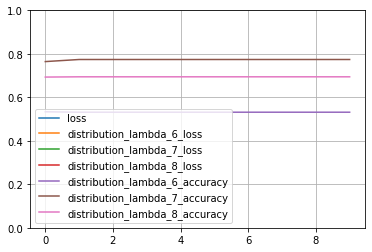

In [ ]:
pd.DataFrame(hist.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.show()

Second Module

In [ ]:
features=keras.layers.Flatten()(Vgg.output)
hidden_1=keras.layers.Dense(16,activation='selu')(features)
hidden_2=keras.layers.Dense(6,activation='softmax')(hidden_1)
output_1=tfp.layers.DistributionLambda(lambda t: tfp.distributions.Bernoulli(probs=t[...,0:2],
                                        dtype=tf.int32),name='output_1')(hidden_2)
output_2=tfp.layers.DistributionLambda(lambda t: tfp.distributions.Bernoulli(probs=t[...,2:4],
                                       dtype=tf.int32),name='output_2')(hidden_2)
output_3=tfp.layers.DistributionLambda(lambda t: tfp.distributions.Bernoulli(probs=t[...,4:],
                                      dtype=tf.int32),name='output_3')(hidden_2)
Mask_layer_1=keras.layers.Dense(64,activation='relu')(features)
Mask_layer_2=keras.layers.Dense(128,activation='relu')(Mask_layer_1)
Mask_layer_3=keras.layers.Dense(256,activation='relu')(Mask_layer_2)
Mask_layer_4=keras.layers.Dense(128*128,activation='sigmoid')(Mask_layer_3)
reshape_1=keras.layers.Reshape((128,128))(Mask_layer_4)
Mask_output=tfp.layers.DistributionLambda(
  lambda t:tfp.distributions.Independent(tfp.distributions.Bernoulli(probs=t),
                              reinterpreted_batch_ndims=2),name='Mask_output')(reshape_1)
Visual_Geometry_Group=keras.models.Model([Vgg.input],
                            [output_1,output_2,output_3,Mask_output])

In [ ]:
Visual_Geometry_Group.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss={
            'output_1':lambda y_true,y_pred:-tf.reduce_sum(y_pred.log_prob(y_true)),
            'output_2':lambda y_true,y_pred:-tf.reduce_sum(y_pred.log_prob(y_true)),
            'output_3':lambda y_true,y_pred:-tf.reduce_sum(y_pred.log_prob(y_true)),
            'Mask_output':'mse'
            #lambda y_true,y_pred:-tf.reduce_sum(y_pred.log_prob(y_true))
            },metrics={
                'output_1':['accuracy'],
                'output_2':['accuracy'],
                'output_3':['accuracy'],
                'Mask_output':['mae']
                })
# y_true,y_pred:tf.reduce_sum(abs(tf.cast(y_pred,dtype=tf.int32)-tf.cast(y_true,dtype=tf.int32)))

In [ ]:
hist=Visual_Geometry_Group.fit(TRAIN_IMAGES,
                               [
                  tf.cast(TRAINING_LABELS['glioma Tumor'].values ,dtype=tf.int32),
                  tf.cast(TRAINING_LABELS['meningioma Tumor'].values ,dtype=tf.int32),
                  tf.cast(TRAINING_LABELS['pituitary Tumor'].values ,dtype=tf.int32),
                  np.array(train_masks).reshape(2500,128,128)
                                ],
                               epochs=50)

Epoch 1/50
79/79 [==============================] - 7s 68ms/step - loss: 74896.7969 - output_1_loss: 42.6875 - output_2_loss: 31.3355 - output_3_loss: 25.5473 - Mask_output_loss: 74797.2188 - output_1_accuracy: 0.5168 - output_2_accuracy: 0.7524 - output_3_accuracy: 0.7288 - Mask_output_mse: 0.0172
Epoch 2/50
79/79 [==============================] - 5s 68ms/step - loss: 70539.0156 - output_1_loss: 33.4583 - output_2_loss: 24.8122 - output_3_loss: 18.9951 - Mask_output_loss: 70461.7500 - output_1_accuracy: 0.5648 - output_2_accuracy: 0.7996 - output_3_accuracy: 0.7516 - Mask_output_mse: 0.0172
Epoch 3/50
79/79 [==============================] - 5s 69ms/step - loss: 67775.6172 - output_1_loss: 30.8564 - output_2_loss: 21.4377 - output_3_loss: 17.7840 - Mask_output_loss: 67705.5391 - output_1_accuracy: 0.5756 - output_2_accuracy: 0.7912 - output_3_accuracy: 0.7604 - Mask_output_mse: 0.0172
Epoch 4/50
79/79 [==============================] - 5s 70ms/step - loss: 65408.1875 - output_1_loss:

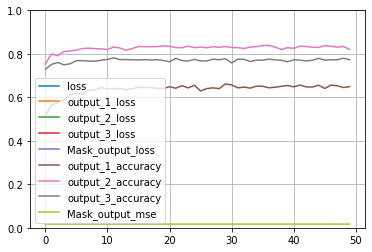

In [ ]:
pd.DataFrame(hist.history).plot() 
plt.grid()
plt.gca().set_ylim(0,1)
plt.show()

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet import ResNet152

Vgg=VGG19(include_top=False, weights='imagenet',input_shape=(128,128,3))
Vgg.trainable=False
inceptionresnetv2=InceptionResNetV2(include_top=False, weights='imagenet',input_shape=(128,128,3))
inceptionresnetv2.trainable=False
inceptionv3=InceptionV3(include_top=False, weights='imagenet',input_shape=(128,128,3))
inceptionv3.trainable=False
resnet152=ResNet152(include_top=False, weights='imagenet',input_shape=(128,128,3))
resnet152.trainable=False

234708992/234698864 [==============================] - 9s 0us/step


In [ ]:
def se_block(in_block, ch, ratio=64):
    x = keras.layers.GlobalAveragePooling2D()(in_block)
    x = keras.layers.Dense(ch//ratio, activation='relu')(x)
    x = keras.layers.Dense(ch, activation='sigmoid')(x)
    x = tf.reshape(x, shape=[-1, 1, 1, ch], name='scaler')
    return keras.layers.multiply([in_block, x])

In [ ]:
features=keras.layers.concatenate([keras.layers.Flatten()(Vgg.output),
                                   keras.layers.Flatten()(inceptionresnetv2.output),
                                  keras.layers.Flatten()( inceptionv3.output),
                                   keras.layers.Flatten()(resnet152.output)])
S_E_Block_1=se_block(Vgg.output,512)
S_E_Block_2=se_block(inceptionresnetv2.output,1536)
S_E_Block_3=se_block(inceptionv3.output,2048)
S_E_Block_4=se_block(resnet152.output,2048)
concat=keras.layers.concatenate([features,keras.layers.Flatten()(S_E_Block_1),
                                 keras.layers.Flatten()(S_E_Block_2),
                                 keras.layers.Flatten()(S_E_Block_3),
                                 keras.layers.Flatten()(S_E_Block_4)])
flatten=keras.layers.Flatten()(concat)
dense_1=keras.layers.Dense(1024,activation='relu')(flatten)
dense_2=keras.layers.Dense(512,activation='relu')(keras.layers.concatenate([dense_1,flatten]))
dense_3=keras.layers.Dense(128,
                        activation='relu')(keras.layers.concatenate([dense_1,dense_2,flatten]))
output_1=keras.layers.Dense(1,activation='sigmoid',
                name='output_1')(keras.layers.concatenate([dense_1,dense_2,dense_3,flatten]))
output_2=keras.layers.Dense(1,activation='sigmoid',
                  name='output_2')(keras.layers.concatenate([dense_1,dense_2,dense_3,flatten]))
output_3=keras.layers.Dense(1,activation='sigmoid',
                name='output_3')(keras.layers.concatenate([dense_1,dense_2,dense_3,flatten]))
SE_Learning_Model=keras.models.Model([Vgg.input,inceptionresnetv2.input,
                                   inceptionv3.input,resnet152.input],
                                   [output_1,output_2,output_3])
SE_Learning_Model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                          loss='binary_crossentropy',metrics=['accuracy'])
hist=SE_Learning_Model.fit([TRAIN_IMAGES,TRAIN_IMAGES,TRAIN_IMAGES,TRAIN_IMAGES],
        [TRAINING_LABELS['glioma Tumor'].values,TRAINING_LABELS['meningioma Tumor'].values,
         TRAINING_LABELS['pituitary Tumor'].values],epochs=10)

Epoch 1/10
 4/88 [>.............................] - ETA: 22:09 - loss: 20.2473 - output_1_loss: 3.2612 - output_2_loss: 6.1080 - output_3_loss: 10.8780 - output_1_accuracy: 0.6016 - output_2_accuracy: 0.6172 - output_3_accuracy: 0.6562

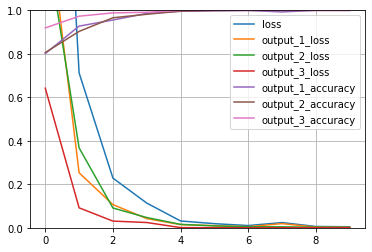

In [ ]:
pd.DataFrame(hist.history).plot() 
plt.grid()
plt.gca().set_ylim(0,1)
plt.show()

In [ ]:
SE_Learning_Model.evaluate([TEST_IMAGES,TEST_IMAGES,TEST_IMAGES,TEST_IMAGES],[
                  tf.cast(TESTING_LABELS['glioma Tumor'].values ,dtype=tf.int32),
                  tf.cast(TESTING_LABELS['meningioma Tumor'].values ,dtype=tf.int32),
                  tf.cast(TESTING_LABELS['pituitary Tumor'].values ,dtype=tf.int32)
])

18/18 [==============================] - 12s 273ms/step - loss: 3.3756 - output_1_loss: 0.9226 - output_2_loss: 0.8875 - output_3_loss: 1.5655 - output_1_accuracy: 0.7128 - output_2_accuracy: 0.7801 - output_3_accuracy: 0.7730


[3.3755834102630615,
 0.922572910785675,
 0.8875243663787842,
 1.5654864311218262,
 0.7127659320831299,
 0.7801418304443359,
 0.7730496525764465]